In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [463]:
tr = pd.read_parquet('train.parquet')

In [464]:
index_split = tr.index.str.split('_')

In [465]:
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)
tr['row_id'] = tr.row_num + '_' + tr.row_type # "уникальный" ряд - уникальная пара (row_num, row_type)

In [658]:
X = tr.pivot(index='row_id', columns='timestamp', values='Values')

In [778]:
X = pd.read_parquet('X.pq')
X = X.pivot(index='row_id', columns='timestamp', values='Values')

In [104]:
X.columns = ['tr_' + str(col) for col in X.columns]

In [661]:
X

timestamp,0,1,2,3,4,5,6,7,8,9,...,17746,17747,17748,17749,17750,17751,17752,17753,17754,17755
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
99_2,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
9_0,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000


In [830]:
def get_times(i):
    a = np.zeros(4)
    for j in range(4):
        a[j] = i + 17756 - 2016 * (j + 1) 
    return a

In [560]:
a

array([ 16,  23,  22, 108,  59,  85,  21,  80, 112,  50])

In [ ]:
def get_prediction(x):
    ...

In [516]:
predictions


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
109_0,131.875,132.75,134.25,135.625,132.5,139.375,133.375,129.875,132.125,134.625,...,63.5,58.375,58.25,54.25,54.0,54.125,51.25,48.625,48.875,46.0
115_0,264.75,265.5,268.5,271.25,264.875,278.75,266.75,258.75,264.375,269.125,...,127.125,116.0,115.75,108.5,107.125,107.375,103.25,96.25,97.75,91.875
121_0,529.375,530.125,537.0,541.0,530.75,557.375,534.375,517.625,529.5,538.5,...,253.125,232.75,232.125,217.125,215.0,214.875,205.875,192.75,195.625,182.25
122_0,529.375,530.125,537.0,541.0,530.75,557.375,534.375,517.625,529.5,538.5,...,253.125,232.75,232.125,217.125,215.0,214.875,205.875,192.75,195.625,182.25
123_0,529.375,530.125,537.0,541.0,530.75,557.375,534.375,517.625,529.5,538.5,...,253.125,232.75,232.125,217.125,215.0,214.875,205.875,192.75,195.625,182.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119_2,66.832765,66.701011,66.858377,66.776562,66.67568,67.205869,66.683822,67.156076,67.304482,67.723801,...,68.990905,68.89289,68.555571,68.680056,67.982366,68.419301,68.097549,68.63796,68.039745,68.314908
120_2,68.813282,68.079056,68.502837,68.425343,67.955759,68.439632,68.55559,68.420878,68.451506,68.836974,...,68.987982,68.780884,68.763609,68.296533,68.971214,68.657679,68.766044,68.851153,68.684941,68.12662
121_2,62.8,61.0,59.6,59.6,59.8,60.6,61.0,61.2,61.0,59.8,...,68.2,68.2,67.9,67.6,67.7,67.7,67.3,67.7,67.4,67.3
122_2,62.8,61.0,59.6,59.6,59.8,60.6,61.0,61.2,61.0,59.8,...,68.2,68.2,67.9,67.6,67.7,67.7,67.3,67.7,67.4,67.3


In [536]:
predictions.index = indices

In [537]:
def f(x):
    return x.name not in indices

In [279]:
f(X.iloc[0])

True

In [304]:
Y = X.copy(deep = True)

In [561]:
a = X.apply(f, axis = 1)

In [774]:
good_index

{'107_0',
 '10_0',
 '10_1',
 '12_2',
 '134_2',
 '143_0',
 '153_0',
 '154_2',
 '160_0',
 '27_2',
 '33_1',
 '56_0',
 '56_2',
 '5_2',
 '64_0',
 '68_2',
 '69_2',
 '78_0'}

In [878]:
for i in range(100):
    X[f'pred_{i}'] = np.mean(X.iloc[:,get_times(i)], axis = 1)
    
    X.loc[list(good_index), f'pred_{i}'] = predictions.loc[list(good_index)].iloc[:,i]
    #X.loc[f'pred_{i}'] = np.mean(X.iloc[:,get_times(i)], axis = 1)

In [879]:
X

timestamp,0,1,2,3,4,5,6,7,8,9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,156.0,155.25,154.25,131.0,140.75,125.5,123.5,126.25,126.0,112.25
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.066125,0.068325,0.069575,0.06145,0.064275,0.056975,0.05815,0.0627,0.059025,0.0541
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,66.5,65.375,64.475,64.725,64.2,65.45,64.9,63.75,63.2,63.5
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,142.5,141.25,139.75,143.5,137.5,133.25,133.5,135.75,124.25,130.5
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.052175,0.052125,0.051225,0.051725,0.0495,0.048275,0.049925,0.050325,0.047475,0.048425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0496,0.052825,0.0472,0.050925,0.045225,0.04555,0.0449,0.0473,0.0421,0.042375
99_2,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,63.75,61.975,62.7,60.875,61.125,61.825,62.975,61.5,62.425,63.2
9_0,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,283.0,298.5,260.5,272.5,217.75,255.5,226.75,229.0,203.25,205.5


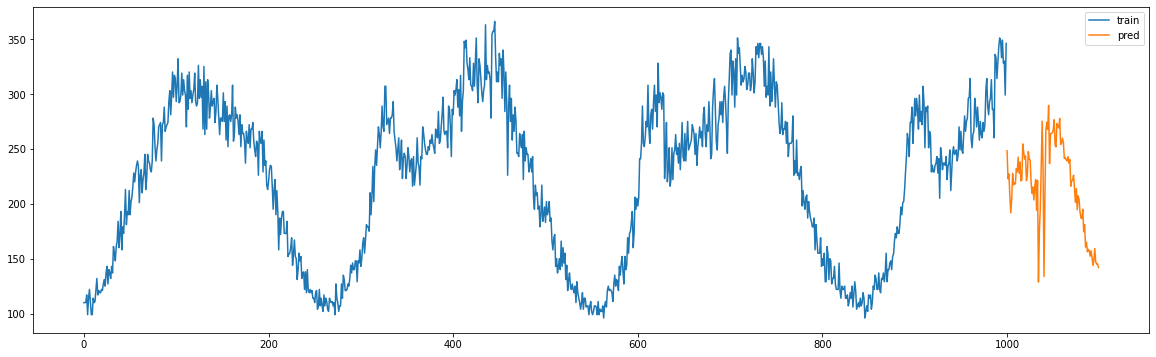

In [869]:
hue_col = ['train'] * 1000 + ['pred'] * 100

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=np.arange(1100), y=X.loc[['107_0']].iloc[0,-1100:].values, hue=hue_col, n_boot=0)
plt.gcf().set_size_inches(20, 6)

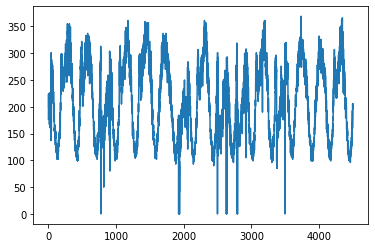

In [722]:
plt.plot(X.loc[['107_0']].values[0,-5000:-500])

In [8]:
tr.to_parquet('X.pq')

In [3]:
from matplotlib import pyplot as plt

In [ ]:
#T = 290
#T_perido = 17310
#T_start = 17600
#T' = T - T_start + T_period

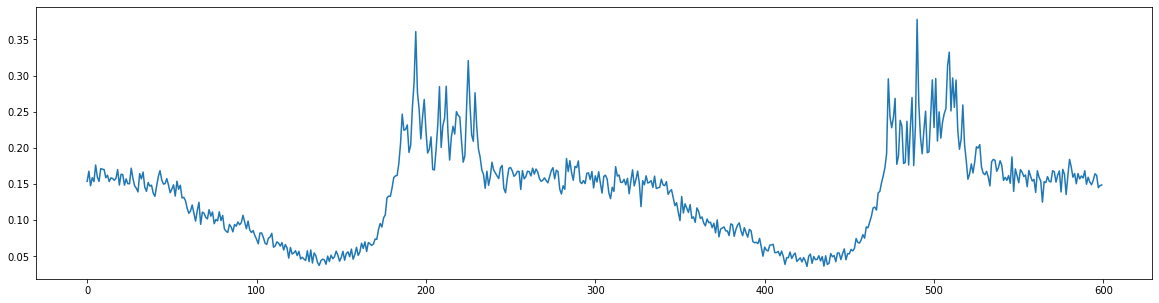

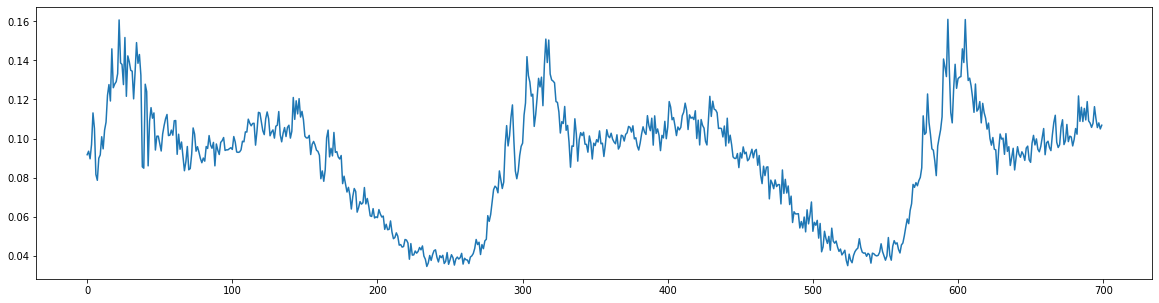

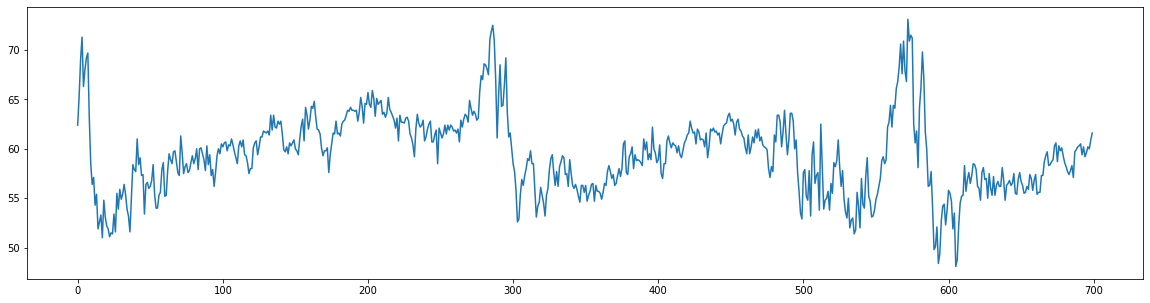

In [209]:
plt.figure(figsize = (20,5))
plt.plot(X.loc['0_1'][-600:].values)
plt.figure(figsize = (20,5))
plt.plot(X.loc['2_1'][-700:].values)
plt.figure(figsize = (20,5))
plt.plot(X.loc['2_2'][-700:].values)

In [111]:
from statsforecast import StatsForecast #Imports the core StatsForecast class
from statsforecast.models import AutoARIMA, ETS, Naive #Imports the models you will use

C:\Users\krasn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [127]:
X.columns

Index(['tr_0', 'tr_1', 'tr_2', 'tr_3', 'tr_4', 'tr_5', 'tr_6', 'tr_7', 'tr_8',
       'tr_9',
       ...
       'tr_17746', 'tr_17747', 'tr_17748', 'tr_17749', 'tr_17750', 'tr_17751',
       'tr_17752', 'tr_17753', 'tr_17754', 'tr_17755'],
      dtype='object', length=17756)

In [880]:
res = X.iloc[:, -100:].melt(ignore_index=False, value_name='Expected', var_name='pred_timestamp')
res

,pred_timestamp,Expected
row_id,,
0_0,pred_0,458.75
0_1,pred_0,0.1506
0_2,pred_0,62.95
100_0,pred_0,301.5
100_1,pred_0,0.10115
...,...,...
99_1,pred_99,0.042375
99_2,pred_99,63.2
9_0,pred_99,205.5


In [881]:
index_split_res = res.index.str.split('_')
res['row_num'] = index_split_res.str.get(0).astype(int)
res['row_type'] = index_split_res.str.get(1).astype(int)
res['timestamp'] = res.pred_timestamp.str.split('_').str.get(1).astype(int)
res['Id'] = res.index + '_' + res.timestamp.astype(str)
res.sort_values(['row_num', 'row_type', 'timestamp'], inplace=True)
res

,pred_timestamp,Expected,row_num,row_type,timestamp,Id
row_id,,,,,,
0_0,pred_0,458.75,0,0,0,0_0_0
0_0,pred_1,473.75,0,0,1,0_0_1
0_0,pred_2,468.25,0,0,2,0_0_2
0_0,pred_3,448.25,0,0,3,0_0_3
0_0,pred_4,431.75,0,0,4,0_0_4
...,...,...,...,...,...,...
169_2,pred_95,65.05,169,2,95,169_2_95
169_2,pred_96,65.075,169,2,96,169_2_96
169_2,pred_97,65.05,169,2,97,169_2_97


In [882]:
res[['Id', 'Expected']].reset_index(drop=True).to_csv('sub.csv', index = False)

In [836]:
res

,pred_timestamp,Expected,row_num,row_type,timestamp,Id
row_id,,,,,,
0_0,pred_0,458.750,0,0,0,0_0_0
0_0,pred_1,473.750,0,0,1,0_0_1
0_0,pred_2,468.250,0,0,2,0_0_2
0_0,pred_3,448.250,0,0,3,0_0_3
0_0,pred_4,431.750,0,0,4,0_0_4
...,...,...,...,...,...,...
169_2,pred_95,65.050,169,2,95,169_2_95
169_2,pred_96,65.075,169,2,96,169_2_96
169_2,pred_97,65.050,169,2,97,169_2_97


In [102]:
import datetime

In [3]:
import statsforecast

C:\Users\krasn\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 0 Value

Делим предсказываемое время на 3 блока:

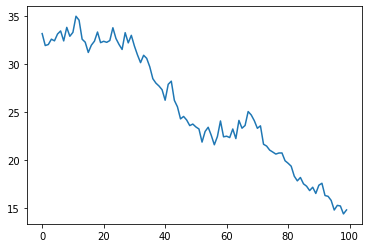

In [6]:
stds = np.array([X.iloc[[3 * i + 0 for i in range(169)],
            [j- i*2016 for i in range(1,9)]].std(axis = 1).mean() for j in range(100)])
#_,_,_ = plt.hist(stds.iloc[[3 * i + 0 for i in range(169)]], bins = 60)
plt.plot(stds)

In [786]:
def make_cv(M):
    if len(M.shape) == 2:
        cv_folds = [] 
        for i in range(1, 7):
            cv_folds.append((M.iloc[:, :-i * 2016], M.iloc[:,-i * 2016: -i * 2016 + 100]))
        return cv_folds
    else:
        cv_folds = [] 
        for i in range(1, 7):
            cv_folds.append((M[:-i * 2016], M[-i * 2016: -i * 2016 + 100]))
        return cv_folds
def make_cv_(M, h = 20):
    if len(M.shape) == 2:
        cv_folds = [] 
        cv_folds.append((M.iloc[:,:-h], M.iloc[:,-h:]))
        #cv_folds.append((M.iloc[:,:-200], M.iloc[:,-200:]))
        print(1)
        return cv_folds
    else:
        cv_folds = []
        cv_folds.append((M.iloc[:-100], M.iloc[-100:]))
        cv_folds.append((M.iloc[:-200], M.iloc[-200:]))
        return cv_folds
    

In [9]:
from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

In [846]:
Mean_score = get_metrics(model_mean(X.values[:,:-150] , h =50),
                         X.values[:,-150:-100],
                         X.values[:,:-150] 
                        )
filter_ = ((Mean_score > 1) & (Mean_score < 5))
filter_.sum()

298

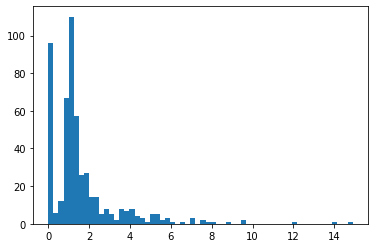

In [791]:
_,_,_ = plt.hist(Mean_score, bins = 60)

In [850]:
predictions

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99


In [865]:
predictions = pd.DataFrame(columns = [i for i in range(100)])
Indices = X.index[filter_]
for i in range(90):
    indices = Indices[i*3:3*(i+1) - 1]
    print(indeces)
    try:
        print(1)
        predictions = pd.concat(
            [pd.DataFrame(model_ardl(X.loc[indices].values[:,:-100]),
                                    index = X.loc[indices].index,
                                    columns = [i for i in range(100)]),
             predictions
            ]
            )
        print(2)
    except Exception as e:
        print(e)
        continue


[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2
[]
1
2


In [866]:
predictions

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
7_2,60.745011,56.019893,51.082515,32.408857,22.315756,27.411654,24.213111,31.48113,30.365171,28.401626,...,66.429311,65.287595,65.494598,65.308061,65.08865,66.082139,70.098698,69.516388,69.22469,68.183237
82_0,207.461657,284.139187,294.077178,299.304368,282.735265,315.646048,300.905284,255.405297,299.375961,288.635029,...,85.594119,83.272097,75.150866,62.204241,72.483894,51.605657,66.312714,51.840686,41.546564,31.554896
79_2,62.210144,61.968231,63.236,62.544863,62.397306,62.830944,62.954659,63.102431,63.074471,62.251007,...,63.481984,63.225089,63.293758,63.395181,63.351438,63.627581,63.562564,63.618314,63.61185,63.503845
7_0,244.250894,249.83679,245.579364,228.779897,219.850254,279.060738,233.808879,257.749484,255.130322,240.697643,...,131.155806,121.735348,123.471764,115.924021,115.168696,107.63252,110.597908,106.364136,113.385358,98.474248
78_2,64.601604,64.626035,64.631369,64.677799,64.719247,64.766526,64.756399,64.553294,64.702512,64.636951,...,63.458486,63.437806,63.455518,63.419455,63.246259,63.248421,63.680917,63.728293,63.807752,63.741979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103_2,64.91617,62.89809,62.46507,62.840259,62.184362,62.528805,60.247182,60.882974,61.868958,62.723798,...,65.153773,65.194458,64.900838,63.963286,63.42736,64.318549,64.910468,64.660862,64.228619,64.031997
102_1,0.058927,0.06145,0.057893,0.064471,0.057558,0.053112,0.055163,0.053423,0.058369,0.068555,...,0.012728,0.008705,0.013925,0.013771,0.015352,0.011478,0.012956,0.013565,0.013175,0.008088
102_2,64.976196,64.03243,64.352198,62.903045,64.233293,60.713915,62.758864,63.84699,65.148067,63.476946,...,65.249539,65.159518,64.059084,63.574104,63.39547,64.509346,64.555491,64.682785,64.798593,64.85377
0_0,447.676108,458.49447,451.070171,449.789911,423.141283,443.854554,484.520048,474.080859,476.347771,473.51748,...,149.661082,157.110231,176.790185,142.412991,150.383242,131.265005,122.222129,129.799598,126.943645,102.337333


In [675]:
predictions

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
row_id,,,,,,,,,,,,,,,,,,,,,
107_0,343.887215,309.815934,325.132079,285.842384,282.959340,277.869177,300.060245,292.091498,273.438064,284.978882,...,158.416417,161.011474,153.955254,142.676054,155.074667,159.271714,148.586205,143.880991,155.565861,146.409443
107_1,0.132780,0.120022,0.117055,0.097439,0.085445,0.078216,0.083713,0.078782,0.073589,0.082146,...,0.052131,0.052205,0.050386,0.048138,0.050864,0.051386,0.049283,0.047711,0.051053,0.048408
10_0,422.012263,463.664469,446.699133,459.839400,450.679653,472.393264,506.936268,511.971199,526.870874,574.591573,...,35.223144,43.367234,43.567262,50.138237,58.466780,55.577632,67.249515,73.334559,70.061831,73.246532
10_1,0.068683,0.072202,0.067733,0.071426,0.065943,0.070348,0.075202,0.075531,0.079313,0.080741,...,0.030509,0.030178,0.031644,0.029300,0.031135,0.032128,0.032886,0.033319,0.033408,0.033646
127_1,0.079395,0.077403,0.079886,0.075688,0.080882,0.076173,0.086524,0.090056,0.085446,0.086624,...,0.049706,0.048598,0.047273,0.048518,0.044447,0.044868,0.043451,0.043318,0.042016,0.040879
129_1,0.080272,0.092993,0.109641,0.097699,0.122558,0.152317,0.115729,0.116706,0.118946,0.127804,...,0.038398,0.036661,0.041294,0.038756,0.036542,0.034587,0.037847,0.035042,0.034687,0.034318
12_1,0.120456,0.120214,0.117331,0.113661,0.111012,0.111942,0.115461,0.115878,0.112761,0.111139,...,0.029900,0.029600,0.027700,0.026200,0.026100,0.025900,0.024900,0.023700,0.022400,0.021500
12_2,62.299683,62.513401,62.748719,63.092391,63.431014,63.341809,63.440007,63.547820,63.438005,63.648350,...,68.199978,68.199980,67.799982,67.399984,67.299986,67.499988,67.599989,67.599991,67.399992,67.399993
132_0,297.011663,309.486203,317.324131,329.982250,393.578175,377.940970,409.293104,409.668991,388.735854,407.588993,...,281.041023,289.518094,271.487215,268.224109,263.982942,249.612576,257.285360,251.697660,237.527958,248.568305


# < 30

In [205]:
predictions = pd.DataFrame(columns = [i for i in range(100)])

Index(['109_0', '115_0', '121_0', '122_0', '123_0', '124_0', '12_0', '131_0',
       '141_0', '142_0', '149_0', '159_0', '28_0', '48_0', '50_0', '51_0',
       '55_0', '61_0', '62_0', '70_0', '73_0', '74_0', '75_0', '80_0', '81_0',
       '83_0', '84_0', '90_0', '91_0'],
      dtype='object', name='row_id')
(117, 100)
(117, 100)
Index(['109_1', '115_1', '121_1', '122_1', '123_1', '12_1', '131_1', '141_1',
       '142_1', '149_1', '159_1', '28_1', '48_1', '50_1', '51_1', '55_1',
       '61_1', '62_1', '70_1', '73_1', '74_1', '75_1', '80_1', '81_1', '83_1',
       '84_1', '90_1', '91_1'],
      dtype='object', name='row_id')
(117, 100)
(117, 100)
Index([], dtype='object', name='row_id')
(117, 100)
(117, 100)


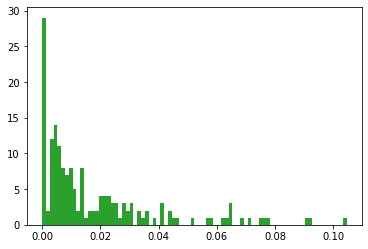

In [219]:
indices = []
for j in range(3):
    #stds_0_30 = X.iloc[[3 * i + j for i in range(169)],[10 - i*2016 for i in range(1,9)]].std(axis = 1) 
    #stds = X.iloc[[3 * i + 1 for i in range(169)],[10 - i*2016 for i in range(1,9)]].std(axis = 1)
    #_,_,_ = plt.hist(stds, bins = 80)
    #stds_noisy_data = stds_0_30.loc[(stds_0_30 > 0) & (stds_0_30 < stds_0_30.mean())]
    #indices += (list(stds_0_30[stds_0_30 == 0].index))
    #indices += (list(stds_noisy_data.index[:20]))
    #print(stds_0_30[stds_0_30 == 0].index)
    #predictions = pd.concat([predictions, model_mean(X.loc[stds_0_30[stds_0_30 == 0].index])])
    print(predictions.shape)
    #predictions = pd.concat([predictions, model_ardl(X.loc[stds_noisy_data.index[:20]])])
    print(predictions.shape)

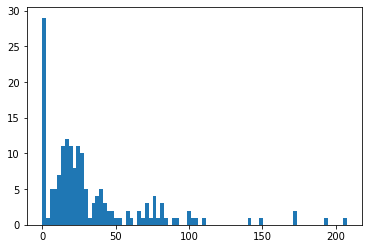

In [292]:
stds_0_30 = X.iloc[[3 * i + 0 for i in range(169)],[10 - i*2016 for i in range(1,9)]].std(axis = 1) 
stds = X.iloc[[3 * i + 0 for i in range(169)],[10 - i*2016 for i in range(1,9)]].std(axis = 1)
_,_,_ = plt.hist(stds, bins = 80)

In [293]:
stds_noisy_data = stds_0_30.loc[(stds_0_30 > 0) & (stds_0_30 < 40)]

In [294]:
stds_noisy_data

row_id
100_0    19.848983
101_0    27.362318
102_0    19.606395
103_0    17.443787
105_0    10.236489
           ...    
95_0     25.694635
96_0     13.583078
97_0     27.280291
98_0     18.515920
99_0     14.759380
Length: 96, dtype: float64

In [12]:
models = [
    AutoARIMA(season_length=288)
]

In [10]:
def time_series(X):
    d = X.copy()
    d.index.rename('unique_id', inplace = 1)
    d = d.melt(ignore_index=False, value_name='y', var_name='ds').iloc[:-1]
    d['ds'] = pd.to_datetime(d['ds'], utc=True, unit='m')
    return d

In [573]:
x = np.array([[1,2], [3,4]])
y = np.array([1,2])
x / y[:, np.newaxis]

array([[1. , 2. ],
       [1.5, 2. ]])

In [620]:
def get_metrics(pred, true, y_train):
    T = y_train.shape[1]
    weight = 1 / (T - 1) * np.sum(np.abs(y_train[:,1:] - y_train[:,:-1]), axis = 1)
    return np.mean(np.abs(pred - true) / weight[:,np.newaxis], axis = 1)
    

In [73]:
import sklearn as sk

In [74]:
from sklearn.linear_model import LinearRegression

In [54]:
def linear_reg(y):
    prediction = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        model = LinearRegression()
        model.fit(X = np.arange(y.shape[1]).reshape(-1,1), y = y[i])
        prediction[i] = model.forecast([[len(y)]])
    return prediction

In [111]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [128]:
from statsmodels.tsa.ardl import ARDL

In [864]:
def model_mean(y_train, h = 100):
    #indices = y_train.index
    N = y_train.shape[1]
    answer = np.zeros((y_train.shape[0], h))
    for i in range(h):
        answer[:,i] = np.mean(y_train[:,[i + N - 2016 * (j + 1) for j in range(4)]], axis =1)
    #answer = pd.DataFrame(answer, columns = [i for i in range(100)])
    #answer.set_index(indices)
    return answer
def arima_model(y_train):
    answer = np.zeros((y_train.shape[0], 100))
    for j in range(y_train.shape[0]):
        model = statsmodels.tsa.arima.model.ARIMA(
                endog = y_train[j],
                order=(1, 0, 1),
                trend="t",
        )
        model = model.fit()
        answer[j] = model.forecast(100, alpha=0.1)
    return answer
def exp_smooth(y_train):
    answer = np.zeros((y_train.shape[0], 100))
    for j in range(y_train.shape[0]):
        model = ExponentialSmoothing(
                endog = y_train[j],
                seasonal_periods = 2016,
                trend = 'additive'
        )
        model = model.fit()
        answer[j] = model.forecast(100)
    return answer
def model_ardl(y_train, h = 100):
    #indices = y_train.index
    #y_train = y_train.values
    y_train = y_train[:, -8000:]
    answer = np.zeros((y_train.shape[0], h))
    for j in range(y_train.shape[0]):
        model = ARDL(
                endog = y_train[j],
                lags = [1,2,3,4,5,288,2016, 2 * 2016],
                seasonal = True, 
                period = 2016
        )
        model = model.fit()
        answer[j] = model.forecast(h)
    #answer = pd.DataFrame(answer, columns = [i for i in range(100)])
    #answer.set_index(indices)
    return answer
    
    

In [569]:
len(a) - a.sum()

117

In [595]:
filtr = np.zeros(X.shape[0], dtype = bool)
filtr[[i for i in range(X.shape[0]) if i % 3 == 0]] = 1
(filtr & ~a).sum()

49

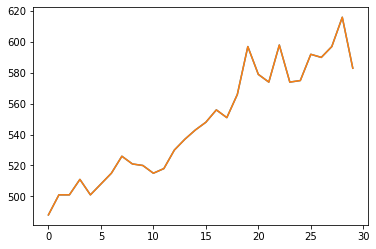

In [640]:
plt.plot(np.arange(30), X.loc['61_0'].iloc[-30:])
plt.plot(model_mean(np.array([X.loc['61_0'].iloc[:-30]]),h=30)[0])
#plt.plot(X.loc['61_0'].iloc[:100])

In [873]:
good_index = set()

In [877]:
len(good_index)

48

In [887]:
a = X.apply(f, axis = 1)
for train, test in make_cv(X.iloc[:,:-100]):
    #sf = statsforecast.StatsForecast(
    #    models = [AutoETS(season_length=2016)],
    #    freq = 'T',
    #    df = time_series(train),
    #)
    y_true = test.values[:,:50]
    y_train = train.values
    y_pred = model_mean(y_train, h= 100)[:,:50]
    scores_mean = get_metrics(y_pred, y_true, y_train)
    print(scores_mean.mean())

2.139617516783455
2.7561997671309144
1.9357532236017463
1.994496871206368
2.8777291457435266
3.591969450308038


In [757]:
import pmdarima as pm

In [22]:
import statsmodels.tsa.arima.model

In [192]:
X.shape

(510, 17856)

In [16]:
from statsmodels.tsa.stattools import kpss

[231. 211. 211. 212. 214. 232. 188. 206. 195. 182. 206. 211. 196. 217.
 200. 209. 209. 206. 207. 195. 200. 189. 195. 211. 206. 200. 196. 203.
 212. 206. 182. 199. 227. 209. 203. 214. 195. 205. 188. 231. 214. 217.
 195. 217. 216. 203. 220. 227. 208. 212. 212. 227. 235. 222. 226. 225.
 246. 234. 246. 232. 238. 224. 241. 235. 217. 237. 241. 221. 229. 257.
 252. 228. 230. 241. 242. 217. 260. 267. 246. 246. 247. 244. 252. 256.
 241. 259. 252. 253. 299. 282. 261. 281. 222. 254. 284. 286. 264. 281.
 288. 291.]
1.707235949965711
[[201.625]
 [211.125]
 [205.875]
 [197.5  ]
 [206.875]
 [195.625]
 [202.875]
 [191.875]
 [180.75 ]
 [192.625]
 [182.375]
 [185.25 ]
 [197.75 ]
 [192.375]
 [199.625]
 [197.25 ]
 [196.625]
 [203.125]
 [196.   ]
 [185.125]
 [185.125]
 [195.375]
 [194.875]
 [188.625]
 [196.75 ]
 [190.375]
 [195.125]
 [192.75 ]
 [200.875]
 [189.5  ]
 [190.625]
 [185.75 ]
 [183.625]
 [194.375]
 [193.375]
 [195.125]
 [199.75 ]
 [193.25 ]
 [197.25 ]
 [201.   ]
 [197.125]
 [199.375]
 [201.   ]


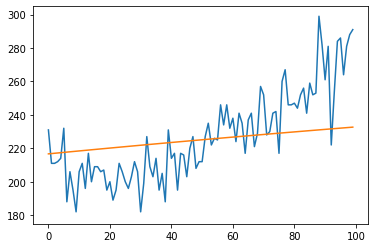

In [95]:
model = statsmodels.tsa.arima.model.ARIMA(
    endog = X.loc[stds_noisy_data.index].iloc[[0]].values[0][:-100],
    order=(1, 0, 1),
    #seasonal_order = (0,0,1,2016),
    trend="t"
)
model = model.fit()
y_pred = model.forecast(100, alpha=0.1)
plt.plot(X.loc[stds_noisy_data.index].iloc[[0]].values[0,-100:])
plt.plot(y_pred)
print(X.loc[stds_noisy_data.index].iloc[[0]].values[0,-100:] )
print(get_metrics(y_pred.reshape(-1,1),
            X.loc[stds_noisy_data.index].iloc[[0]].values[:,-100:],
           X.loc[stds_noisy_data.index].iloc[[0]].values[:,:-100] ))

y_pred_ = model_mean(X.loc[stds_noisy_data.index].iloc[[0]].values[:,:-100])
print(y_pred_[0].reshape(-1,1))
print(get_metrics(y_pred_,
            X.loc[stds_noisy_data.index].iloc[[0]].values[:,-100:],
            X.loc[stds_noisy_data.index].iloc[[0]].values[:,:-100] ))
plt.plot(X.loc[stds_noisy_data.index].iloc[[0]].values[:,-100:])
plt.plot(y_pred_)
